In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import geopandas as gpd
import mlbox as mlb

In [39]:
df = pd.read_csv("Houses.csv")
df.drop(['url', 'source', 'scrapDate', 'images', 'html', 'locationPin', 'localityComplete'], axis='columns', inplace=True)

# Maybe some more data cleaning (oulier detection, column type enforce)

df.head()

test = df.sample(frac=0.25)
train = df.drop(test.index)

test.rename(columns={'price':''}, inplace=True)
test.to_csv("Houses_test.csv")
train.to_csv("Houses_train.csv")

In [41]:
df = mlb.Reader(sep=',').train_test_split(['Houses_train.csv', 'Houses_test.csv'], 'price')


reading csv : Houses_train.csv ...
cleaning data ...
CPU time: 5.402289152145386 seconds

reading csv : Houses_test.csv ...
cleaning data ...
CPU time: 0.15093588829040527 seconds

> Number of common features : 22

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 12
> Number of numerical features: 10
> Number of training samples : 30110
> Number of test samples : 10036

> Top sparse features (% missing values on train set):
terraceArea               90.1
noFronturi                81.5
noTerrace                 77.5
originalTotalGrossArea    74.4
roofMaterial              72.1
dtype: float64

> Task : regression
count    3.011000e+04
mean     1.790204e+05
std      3.357302e+05
min      0.000000e+00
25%      6.950000e+04
50%      1.080000e+05
75%      1.860000e+05
max      2.076800e+07
Name: price, dtype: float64


In [43]:
dft = mlb.Drift_thresholder()
df = dft.fit_transform(df)


computing drifts ...
CPU time: 5.760206460952759 seconds

> Top 10 drifts

('_id', 0.9999335768847559)
('usableArea', 0.9996480885352088)
('area', 0.07828093853823326)
('locality', 0.036977190979957886)
('constructionYearRange', 0.008662637156518826)
('kitchens', 0.00755389531595263)
('district', 0.006344618688562953)
('frontStradal', 0.005999868424518606)
('roofMaterial', 0.005771993986709356)
('constructionYear', 0.005301393230798812)

> Deleted variables : ['_id', 'usableArea']
> Drift coefficients dumped into directory : save


In [45]:
opt = mlb.Optimiser(n_folds = 4)
space_xgb={
'ne__numerical_strategy'    :{"search":"choice",
                              "space":[0,'mean','median','most_frequent']},
'ne__categorical_strategy'  :{"search":"choice",
                              "space":["<NULL>"]},
'ce__strategy'              :{"search":"choice",
                              "space":['entity_embedding']},
'fs__strategy'              :{"search":"choice",
                              "space":['l1','variance','rf_feature_importance']},
'fs__threshold'             :{"search":"uniform",
                              "space":[0.01,0.6]},
'est__max_depth'            :{"search":"choice",
                              "space":[3,4,5,6,7]},
'est__learning_rate'        :{"search":"uniform",
                              "space":[0.01,0.1]},
'est__subsample'            :{"search":"uniform",
                              "space":[0.4,0.9]},
'est__reg_alpha'            :{"search":"uniform",
                              "space":[0,10]},
'est__reg_lambda'           :{"search":"uniform",
                              "space":[0,10]},
'est__n_estimators'         :{"search":"choice",
                              "space":[1000,1250,1500]}
}

best = opt.optimise(space_xgb, df, 20)

##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'entity_embedding'}
>>> FEATURE SELECTOR :{'strategy': 'rf_feature_importance', 'threshold': 0.3355717962587246}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'learning_rate': 0.04470325977977593, 'max_depth': 3, 'n_estimators': 1500, 'reg_alpha': 6.042912546404939, 'reg_lambda': 2.9532607328848295, 'subsample': 0.5472685635258845, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/home/alex/Documents/ngnt/matching/MLBox/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 0.57s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 0.75s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The r

MEAN SCORE : neg_mean_squared_error = -61931297164.57182
VARIANCE : 28647497425.042652 (fold 1 = -38235433586.70849, fold 2 = -33563198429.365467, fold 3 = -71212974257.42168, fold 4 = -104713582384.79167)
CPU time: 132.67873549461365 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'most_frequent', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'entity_embedding'}
>>> FEATURE SELECTOR :{'strategy': 'variance', 'threshold': 0.47098194573014074}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'learning_rate': 0.0915680400277287, 'max_depth': 6, 'n_estimators': 1000, 'reg_alpha': 5.786225809363783, 'reg_lambda': 1.3136608884029721, 'subsample': 0.8356219803085598, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 0.56s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 0.65s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])

/h

MEAN SCORE : neg_mean_squared_error = -64975775286.29007
VARIANCE : 24903392999.234425 (fold 1 = -40936883968.84389, fold 2 = -46577187984.81534, fold 3 = -67975433591.62724, fold 4 = -104413595599.8738)
CPU time: 93.55400061607361 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'entity_embedding'}
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.588698167629915}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'learning_rate': 0.040025651385965234, 'max_depth': 5, 'n_estimators': 1500, 'reg_alpha': 4.820053041136329, 'reg_lambda': 8.336295164300772, 'subsample': 0.8896084252160978, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'obj

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216911061945538.75, tolerance: 281152902801.65784
  positive)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293020020505485.6, tolerance: 285006092942.27277
  positive)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153674928766023.25, tolerance: 243852753197.74167
  positive)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the

MEAN SCORE : neg_mean_squared_error = -77820267275.38115
VARIANCE : 30456443684.26933 (fold 1 = -61361936952.62771, fold 2 = -41676850147.93316, fold 3 = -84760295312.5564, fold 4 = -123481986688.40733)
CPU time: 19.37880778312683 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'entity_embedding'}
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.06804873821187518}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'learning_rate': 0.05928378750592377, 'max_depth': 5, 'n_estimators': 1500, 'reg_alpha': 6.453869773955772, 'reg_lambda': 1.7637902748997714, 'subsample': 0.856033311044464, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31,

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 0.56s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 0.63s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])

/h

MEAN SCORE : neg_mean_squared_error = -64671698246.06064
VARIANCE : 26463468476.09111 (fold 1 = -40232935814.983475, fold 2 = -43507505726.591095, fold 3 = -68548723934.48326, fold 4 = -106397627508.18474)
CPU time: 106.47084879875183 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'entity_embedding'}
>>> FEATURE SELECTOR :{'strategy': 'variance', 'threshold': 0.5981096381563183}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'learning_rate': 0.04915807985011378, 'max_depth': 5, 'n_estimators': 1000, 'reg_alpha': 0.46615385738059567, 'reg_lambda': 6.805269655991268, 'subsample': 0.5602530381521836, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216911061945538.75, tolerance: 281152902801.65784
  positive)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293020020505485.6, tolerance: 285006092942.27277
  positive)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153674928766023.25, tolerance: 243852753197.74167
  positive)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the

MEAN SCORE : neg_mean_squared_error = -60834931448.53431
VARIANCE : 29380509545.24186 (fold 1 = -38610352734.7547, fold 2 = -29477079282.085415, fold 3 = -71193372875.45906, fold 4 = -104058920901.83804)
CPU time: 18.425902843475342 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'entity_embedding'}
>>> FEATURE SELECTOR :{'strategy': 'variance', 'threshold': 0.13681603390839445}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'learning_rate': 0.054146581596519125, 'max_depth': 7, 'n_estimators': 1250, 'reg_alpha': 5.382822925108108, 'reg_lambda': 1.1384581138938432, 'subsample': 0.40404950592073297, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_l

/home/alex/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



MEAN SCORE : neg_mean_squared_error = -63056734486.00058
VARIANCE : 26449436529.959824 (fold 1 = -42399489550.349266, fold 2 = -36857055340.05689, fold 3 = -69348100096.3431, fold 4 = -103622292957.25305)
CPU time: 78.33370637893677 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'entity_embedding'}
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.19417452209516287}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'learning_rate': 0.02491152431498802, 'max_depth': 3, 'n_estimators': 1500, 'reg_alpha': 8.975176541204284, 'reg_lambda': 2.114867581152872, 'subsample': 0.505652669285729, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 0.57s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 0.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])

/h

MEAN SCORE : neg_mean_squared_error = -59899466565.824936
VARIANCE : 30758528970.894787 (fold 1 = -37035115905.36536, fold 2 = -26775848480.04921, fold 3 = -70615292914.54663, fold 4 = -105171608963.33856)
CPU time: 134.79227423667908 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'entity_embedding'}
>>> FEATURE SELECTOR :{'strategy': 'rf_feature_importance', 'threshold': 0.4216605221632561}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'learning_rate': 0.05872670292441521, 'max_depth': 7, 'n_estimators': 1500, 'reg_alpha': 7.015470842580549, 'reg_lambda': 0.30964426366860254, 'subsample': 0.42159015775142505, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 638644533243714.2, tolerance: 281152902801.65784
  positive)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271180199454793.12, tolerance: 285006092942.27277
  positive)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 502276886036739.9, tolerance: 243852753197.74167
  positive)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the 

MEAN SCORE : neg_mean_squared_error = -61165735156.82057
VARIANCE : 29398098787.3935 (fold 1 = -37497898802.97041, fold 2 = -31937545424.822845, fold 3 = -69675736761.26909, fold 4 = -105551759638.21994)
CPU time: 24.13498282432556 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'most_frequent', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'entity_embedding'}
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.1539418000612221}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'learning_rate': 0.015243517838343771, 'max_depth': 4, 'n_estimators': 1500, 'reg_alpha': 5.857209215889992, 'reg_lambda': 2.952234942944223, 'subsample': 0.7178722875026823, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_le

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4284175359178.0, tolerance: 281152902801.65784
  positive)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 635967232640853.2, tolerance: 285006092942.27277
  positive)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546031424121694.7, tolerance: 243852753197.74167
  positive)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the num

MEAN SCORE : neg_mean_squared_error = -58415437836.53264
VARIANCE : 30120860107.22646 (fold 1 = -36470874591.27259, fold 2 = -25972440149.831013, fold 3 = -68060008813.08123, fold 4 = -103158427791.94572)
CPU time: 24.4437997341156 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'entity_embedding'}
>>> FEATURE SELECTOR :{'strategy': 'variance', 'threshold': 0.3366858335654852}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'learning_rate': 0.03618287378543853, 'max_depth': 4, 'n_estimators': 1250, 'reg_alpha': 3.6942945494740123, 'reg_lambda': 4.866077562625431, 'subsample': 0.6873103713533009, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_lea

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216911061945538.75, tolerance: 281152902801.65784
  positive)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293020020505485.6, tolerance: 285006092942.27277
  positive)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153674928766023.25, tolerance: 243852753197.74167
  positive)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the

MEAN SCORE : neg_mean_squared_error = -66401402231.64943
VARIANCE : 24165054051.33144 (fold 1 = -47613303116.38014, fold 2 = -42062965916.32321, fold 3 = -72790709200.79552, fold 4 = -103138630693.09885)
CPU time: 32.10038232803345 seconds
100%|██████████| 20/20 [16:51<00:00, 50.58s/trial, best loss: 58335384115.81794]


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ BEST HYPER-PARAMETERS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'ce__strategy': 'entity_embedding', 'est__learning_rate': 0.01040903940774341, 'est__max_depth': 5, 'est__n_estimators': 1000, 'est__reg_alpha': 9.517742581231515, 'est__reg_lambda': 5.811411798142657, 'est__subsample': 0.7699603097464431, 'fs__strategy': 'vari


fitting the pipeline ...


/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 0.75s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 0.84s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


CPU time: 30.678560972213745 seconds


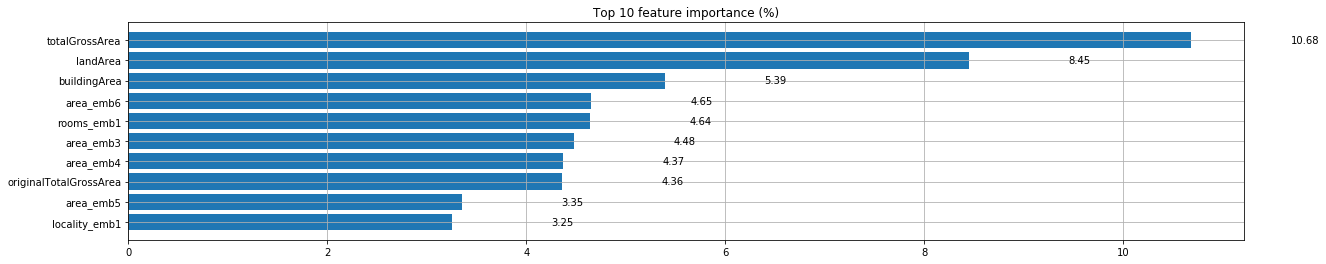


> Feature importances dumped into directory : save

predicting...
USING MY WAYYY
CPU time: 1.6856439113616943 seconds

> Overview on predictions : 

   price_predicted
0    112722.759422
1     82000.977410
2    129512.396511
3    261872.436269
4     58928.306356
5    479592.847996
6    175270.433574
7    251731.903080
8    446697.132085
9     75891.141351

dumping predictions into directory : save ...


In [46]:
prd = mlb.Predictor()
prd.fit_predict(best, df)

27000000.0


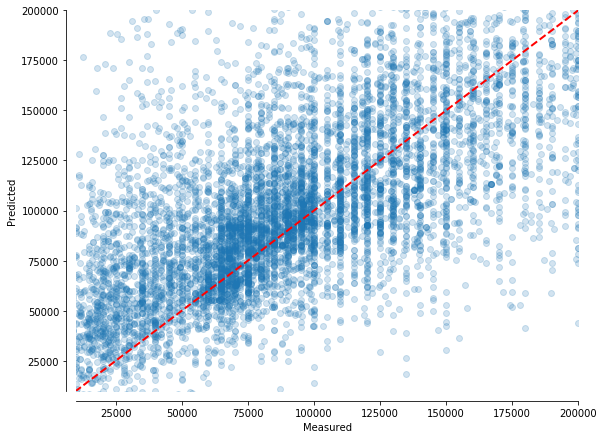

In [50]:
import matplotlib.pyplot as plt
import numpy as  np

def plot_regression_results(ax, y_true, y_pred):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)
    
    ax.set_xlim([10000, 200000])
    ax.set_ylim([10000, 200000])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
#     ax.set_xlim([y_true.min(), y_true.max()])
#     ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    plt.show()
    
pred = pd.read_csv("save/price_predictions.csv")
true = pd.read_csv("Houses_test.csv")

y_pred = pred["price_predicted"]
y_true = true[true.columns[2]]

fig, axs = plt.subplots(1, 1, figsize=(9, 7))
axs = np.ravel(axs)

print(max(y_true.values))

plot_regression_results(axs[0], y_true, y_pred)

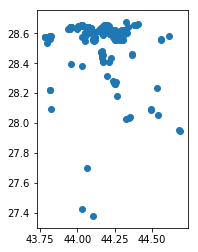

In [60]:
df_test = pd.read_csv('Houses_test.csv')
df_train = pd.read_csv('Houses_train.csv')
import geopandas
ct_test = df_test[df_test.district == "CT"]
gdf_ct =geopandas.GeoDataFrame(ct_test, geometry=geopandas.points_from_xy(ct_test.lat, ct_test.lng))

gdf_ct.plot()

# for index, row in df_test.iterrows():
    

In [80]:
# gdf_ct = gdf_ct.set_crs(epsg=3857)

plm = gpd.GeoDataFrame(gdf_ct, crs= {"init": "epsg:4326"})
plm.to_crs(epsg=3857)

,Unnamed: 0,_id,Unnamed: 2,lat,lng,district,area,locality,rooms,usableArea,...,terraceArea,landArea,noFronturi,frontStradal,roofMaterial,constructionYear,structure,originalTotalGrossArea,constructionYearRange,geometry
15,8734,6ST11000075,48000.0,NaN,NaN,CT,NaN,Valu lui Traian,3,80.0,...,NaN,215.0,NaN,8.0,NaN,2019,NaN,NaN,dupa2000,POINT (nan nan)
16,7423,62J01JHJEEV,358000.0,NaN,NaN,CT,Sud,Ovidiu,4,NaN,...,NaN,535.0,1.0,NaN,NaN,După 2010,NaN,270.0,dupa2000,POINT (nan nan)
24,4317,4AF1100K23P,288900.0,NaN,NaN,CT,Central,Ovidiu,10,460.0,...,NaN,406.0,NaN,NaN,NaN,2008,NaN,500.0,dupa2000,POINT (nan nan)
43,9901,7IT01J6AGGJ,115000.0,44.257942,28.566739,CT,Central,Ovidiu,4,115.0,...,NaN,960.0,1.0,10.0,Tigla,Între 1977 şi 1990,NaN,135.0,intre1977si2000,POINT (4926771.589 3320616.332)
81,23562,fzEh,90000.0,44.286772,28.557533,CT,Lumina,Lumina,6,170.0,...,NaN,500.0,NaN,NaN,NaN,2019,NaN,NaN,dupa2000,POINT (4929980.908 3319449.536)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9911,4750,4K011000075,245000.0,NaN,NaN,CT,Km 5,Constanta,6,200.0,...,NaN,500.0,NaN,NaN,NaN,2014,NaN,NaN,dupa2000,POINT (nan nan)
9940,23563,fzEo,115000.0,44.293307,28.562238,CT,Lumina,Lumina,5,230.0,...,NaN,1200.0,NaN,NaN,NaN,2010,NaN,NaN,dupa2000,POINT (4930708.381 3320045.855)
9985,20297,dohc,370000.0,44.073950,28.638873,CT,Eforie Nord,Eforie,9,600.0,...,NaN,300.0,NaN,NaN,NaN,2005,NaN,NaN,dupa2000,POINT (4906289.660 3329762.402)
9992,37056,hbab,135000.0,44.173330,28.638330,CT,Constanta,Constanta,4,160.0,...,NaN,160.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (4917352.602 3329693.590)


In [82]:
!pip install contextily

    100% |████████████████████████████████| 18.2MB 2.2MB/s 
    100% |████████████████████████████████| 122kB 5.1MB/s 


KeyboardInterrupt: 

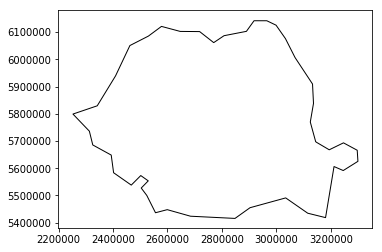

In [90]:
import contextily as ctx

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ro = world[world.name=='Romania'];
ro = ro.to_crs(epsg=3857)

# We restrict to South America.
ax = ro.plot(
    color='white', edgecolor='black')

# choose any of the supported maps from ctx.sources
ctx.add_basemap(ax, url=ctx.sources.ST_TERRAIN, zoom=10)
ax.set_axis_off()
plt.show()